# Echo RNN tutorial
From https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767

## Setup
We will build a simple Echo-RNN that remembers the input data and then echoes it after a few time-steps. First let’s set some constants we’ll need, what they mean will become clear in a moment. 

In [2]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams['figure.facecolor'] = 'white'

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

## Generate data
Now generate the training data, the input is basically a random binary vector. The output will be the “echo” of the input, shifted echo_step steps to the right.

Q: why is reshaping the series here a good idea? If the whole point is to have y remember x some # of steps in the past, then it seems like we're destorying the autocorrelation by reshaping?

In [3]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))  # row of values {1, 2}, with prob {0.5, 0.5}
    y = np.roll(x, echo_step)  # move data forward by echo_step, ex. [1,2,3,4] -> [4,1,2,3]
    y[0:echo_step] = 0

    # convert from row to (batch_size x column)
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

## Building the computational graph

In [47]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])


W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

### Unpacking
Now it’s time to build the part of the graph that resembles the actual RNN computation, first we want to split the batch data into adjacent time-steps.

That is done by unpacking the columns (axis = 1) of the batch into a Python list.
The RNN will simultaneously be training on different parts in the time-series.

The fact that the training is done on three places simultaneously in our time-series,
requires us to save three instances of states when propagating forward.
That has already been accounted for, as you see that the ```init_state``` placeholder has ```batch_size``` rows.

In [50]:
# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass
Notice the concatenation on line 6, what we actually want to do is calculate the sum of two affine transforms 
```current_input``` $\times$ ```Wa``` $+$ ```current_state``` $\times$ ```Wb``` in the figure below.
By concatenating those two tensors you will only use one matrix multiplication.
The addition of the bias b is broadcasted on all samples in the batch.
![](https://cdn-images-1.medium.com/max/800/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png)

In [69]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

In [87]:
# ---------------------------
# This code is suppose to be able to replace above cell
# however it doesn't run due to outdated version of tf
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
states_series, current_state = tf.nn.rnn(cell, inputs_series, init_state)

AttributeError: 'module' object has no attribute 'rnn_cell'

## Loss

The last line is adding the training functionality,
TensorFlow will perform back-propagation for us automatically — the computation graph 
is executed once for each mini-batch and the network-weights are updated incrementally.

Notice the API call to sparse_softmax_cross_entropy_with_logits,
it automatically calculates the softmax internally and then computes the cross-entropy.
In our example the classes are mutually exclusive (they are either zero or one),
which is the reason for using the “Sparse-softmax”, you can read more about it in the API.
The usage is to have ``logits`` is of shape ```[batch_size, num_classes]``` and ```labels``` of shape ```[batch_size]```.

In [72]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for\
          logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

## Visualizing the training

In [74]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

## Run training session

You can see that we are moving truncated_backprop_length steps forward on each iteration (line 15–19),
but it is possible have different strides. This subject is further elaborated in [this article](https://r2rt.com/styles-of-truncated-backpropagation.html).
The downside with doing this is that truncated_backprop_length need to be significantly larger than the time dependencies
(three steps in our case) in order to encapsulate the relevant training data.
Otherwise there might a lot of “misses”, as you can see on the figure below.

![](https://cdn-images-1.medium.com/max/800/1*uKuUKp_m55zAPCzaIemucA.png)

New data, epoch 0
Step 0 Loss 0.686392


KeyboardInterrupt: 

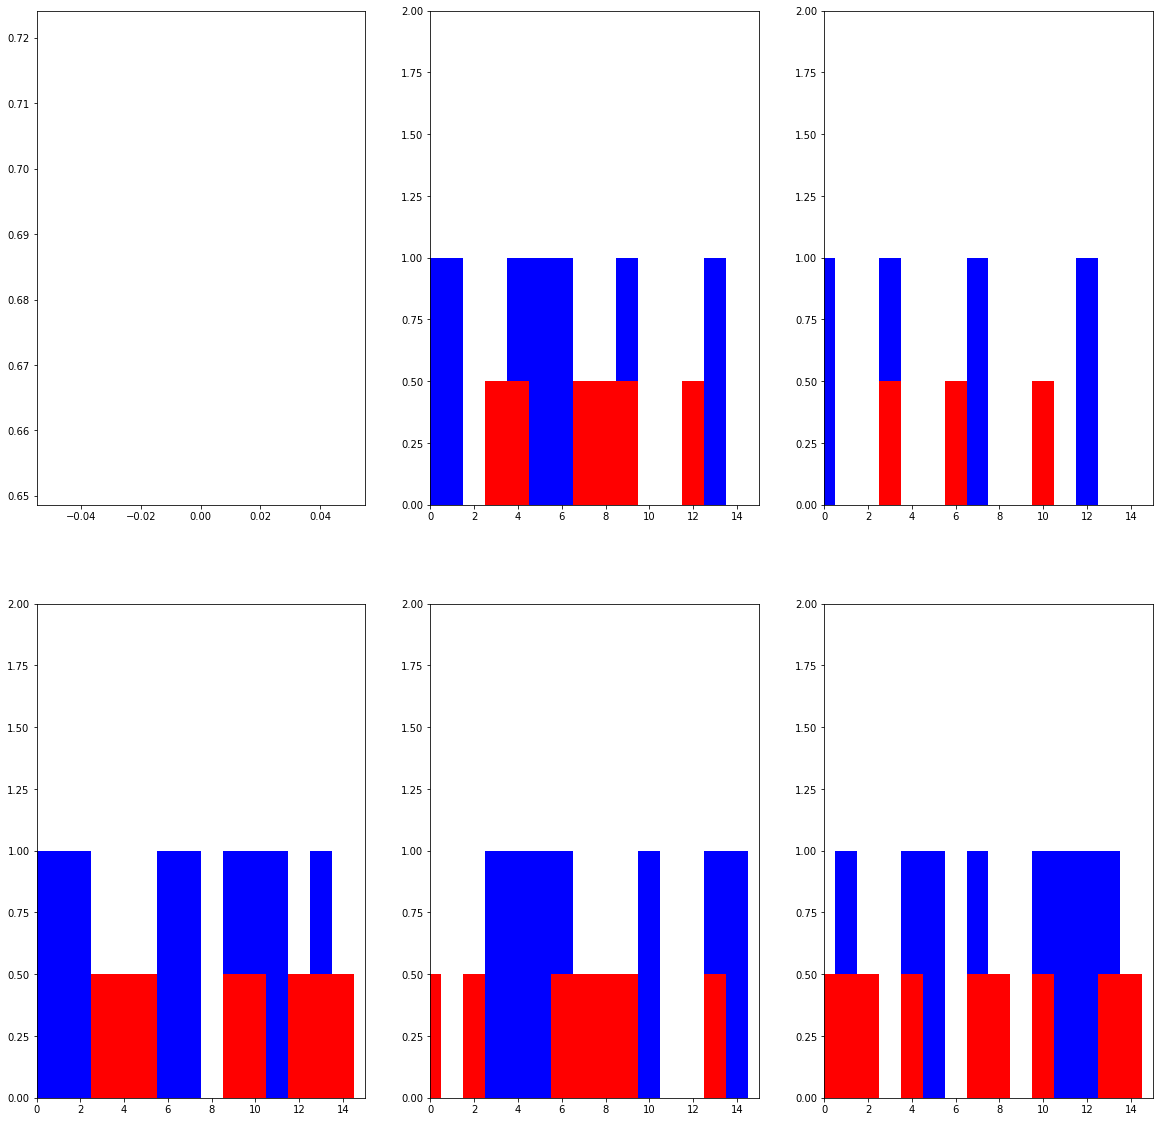

In [77]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()